<a href="https://colab.research.google.com/github/HaidyTalaat/Reinforcement-Learning-Project-Maze-Solving-Self-Driving-Car/blob/mariam-building-DQN-model/building_custom_environment_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Definition :**<br>
**Self-driving car that solves maze by finding shortest path and avoid obstacles that appears in the way.**


# **1. Importing Dependecies**

In [ ]:
!pip install pygame
!pip install tensorflow

In [ ]:
import numpy as np
import gym
from gym import Env
from gym.spaces import Discrete, Box
import pygame
from google.colab import files
from IPython.display import Image, display
import random
import time
import cv2
import glob
import os
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

# **2. Building Custom Maze Environment**

In [ ]:
class CustomMazeEnv(Env):
    def __init__(self, render_mode="rgb_array"):
        super().__init__()
        self.total_reward = 0  # Initialize cumulative reward

        # Maze structure
        self.maze = np.array([
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 3, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1],
            [1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1],
            [1, 0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 1, 0, 4],
            [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
            [1, 0, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
            [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
            [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1],
            [1, 0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1],
            [1, 0, 0, 1, 1, 1, 0, 2, 0, 0, 2, 2, 0, 1],
            [1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
        ])

        self.start_pos = np.argwhere(self.maze == 3)[0]
        self.goal_pos = np.argwhere(self.maze == 4)[0]
        self.agent_pos = self.start_pos.copy()

        self.action_space = Discrete(4)
        self.observation_space = Box(low=np.array([0, 0]), high=np.array([14, 13]), dtype=np.int32)
        self.render_mode = render_mode

        pygame.init()
        # the size of each square of the maze
        self.cell_size = 40
        # total size of the screen =rows*columns*cell_size (14,13)*40
        self.screen = pygame.display.set_mode((self.maze.shape[1] * self.cell_size, self.maze.shape[0] * self.cell_size))
        pygame.display.set_caption("Custom Maze Environment")

    def reset(self):
        #resets the environment but keeps the total reward
        self.agent_pos = self.start_pos.copy()
        self.total_reward = 0  # Reset cumulative reward
        return np.array(self.agent_pos, dtype=np.int32)

    def _avoided_obstacle(self, old_pos, new_pos):
        x, y = old_pos
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # 4 directions
            if (x + dx, y + dy) != new_pos and self.maze[x + dx, y + dy] == 2:
                return True  # found an obstacle nearby but didn't step on it
        return False

    def step(self, action):
        #Takes an action and updates the state with rewards
        x, y = self.agent_pos
        old_pos = (x, y)

        if action == 0:
            new_x, new_y = x - 1, y  # left
        elif action == 1:
            new_x, new_y = x + 1, y  # right
        elif action == 2:
            new_x, new_y = x, y - 1  # up
        elif action == 3:
            new_x, new_y = x, y + 1  # down

        done = False
        expected_maze_value = self.maze[new_x, new_y] if 0 <= new_x < self.maze.shape[0] and 0 <= new_y < self.maze.shape[1] else 1
        reward = 0
        if expected_maze_value == 1 or expected_maze_value == 2:
            reward = -10  # Hitting wall or obstacle
        else:
            self.agent_pos = [new_x, new_y]
            if (new_x, new_y) == tuple(self.goal_pos):
                reward = 100
                done = True
            elif self._avoided_obstacle(old_pos, (new_x, new_y)):
                reward = 5

        self.total_reward += reward
        return np.array(self.agent_pos, dtype=np.int32), self.total_reward, done, expected_maze_value

    def render(self, save_as_image=False, image_path="/content/maze_image.png"):
        self.screen.fill((255, 255, 255))
        colors = {1: (0, 0, 0), 2: (255, 0, 0), 3: (0, 255, 0), 4: (0, 0, 255), 0: (255, 255, 255)}

        for r in range(self.maze.shape[0]):
            for c in range(self.maze.shape[1]):
                pygame.draw.rect(self.screen, colors[self.maze[r, c]], (c * self.cell_size, r * self.cell_size, self.cell_size, self.cell_size))
                pygame.draw.rect(self.screen, (0, 0, 0), (c * self.cell_size, r * self.cell_size, self.cell_size, self.cell_size), 1)
        # to draw the agent as yellow
        pygame.draw.circle(self.screen, (255, 255, 0), (self.agent_pos[1] * self.cell_size + self.cell_size // 2, self.agent_pos[0] * self.cell_size + self.cell_size // 2), self.cell_size // 3)
        pygame.display.flip()

        # Save the rendered maze to an image file if required
        if save_as_image:
            pygame.image.save(self.screen, image_path)
            print(f"Maze image saved as {image_path}")
            files.download(image_path)

            # Display the image in Colab
            display(Image(filename=image_path))

    def close(self):
        pygame.quit()


Maze image saved as /content/maze_image.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

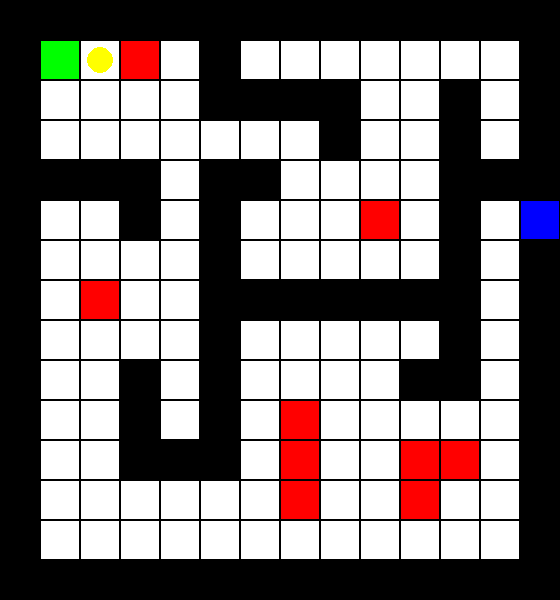

In [ ]:
env = CustomMazeEnv()
state = env.reset()
done = False

# Simulate a few steps and render/save the maze
while not done:
    action = 3  # Example action (move down)
    next_state, reward, done, maze_value = env.step(action)
    env.render(save_as_image=True, image_path="/content/maze_image.png")
    break

# **3. Allowing agent to solve maze using random actions**

In [ ]:
episodes = 20
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    total_comulative_reward = 0

    while not done:
        env.render()
        action = np.random.choice([0,1,2,3])
        n_state, reward, done, maze_value = env.step(action)
        total_comulative_reward+=reward
    print('Episode:{} Total Comulative Reward:{}'.format(episode, total_comulative_reward))

Episode:1 Total Comulative Reward:-11699495
Episode:2 Total Comulative Reward:-4371375
Episode:3 Total Comulative Reward:-324693245
Episode:4 Total Comulative Reward:-448300145
Episode:5 Total Comulative Reward:-80032870
Episode:6 Total Comulative Reward:-32503800
Episode:7 Total Comulative Reward:-24751320
Episode:8 Total Comulative Reward:-8352465
Episode:9 Total Comulative Reward:-2830165
Episode:10 Total Comulative Reward:-697530
Episode:11 Total Comulative Reward:-93778520
Episode:12 Total Comulative Reward:-647145
Episode:13 Total Comulative Reward:-327818275
Episode:14 Total Comulative Reward:-576821510
Episode:15 Total Comulative Reward:-5226450
Episode:16 Total Comulative Reward:-111212635
Episode:17 Total Comulative Reward:-809395
Episode:18 Total Comulative Reward:-41528460
Episode:19 Total Comulative Reward:-617735
Episode:20 Total Comulative Reward:-11519465


**Trying to show the final frame of each episode to check whether agent has reached to the goal or not.**

Maze image saved as /content/maze_episode_1.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

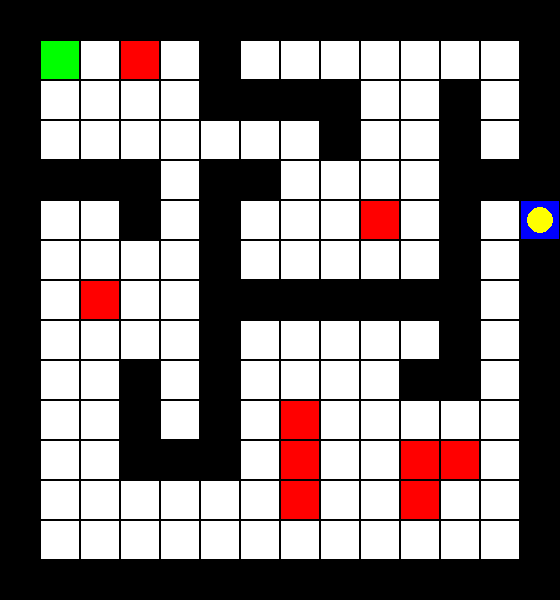

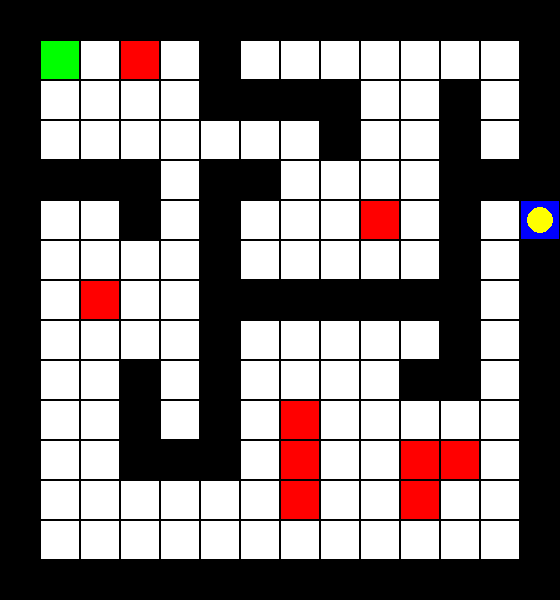

Episode: 1 Score: -156210320
Maze image saved as /content/maze_episode_2.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

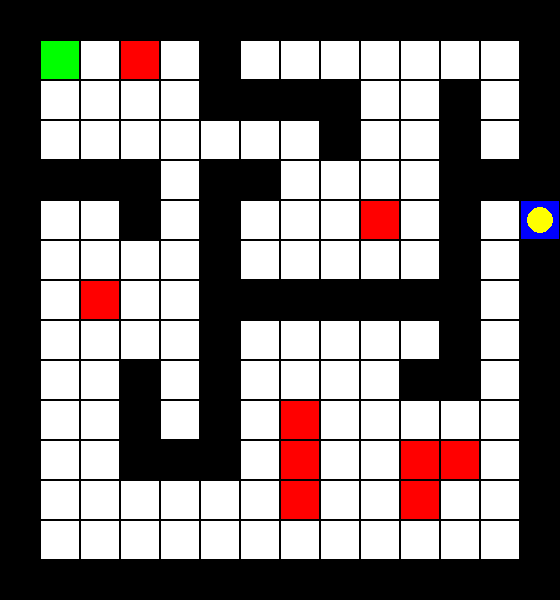

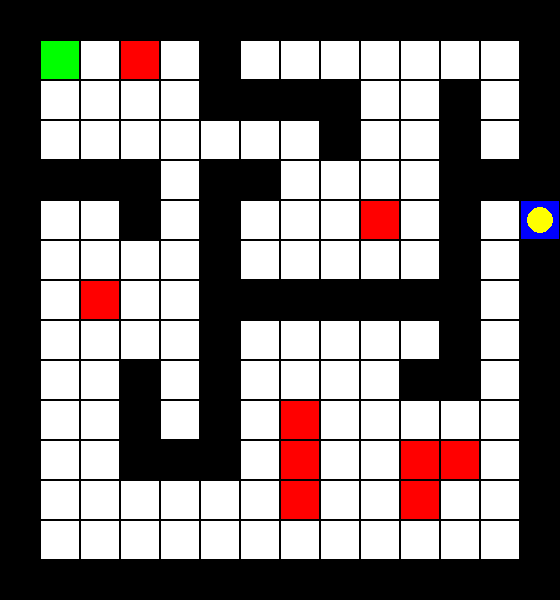

Episode: 2 Score: -288502315
Maze image saved as /content/maze_episode_3.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

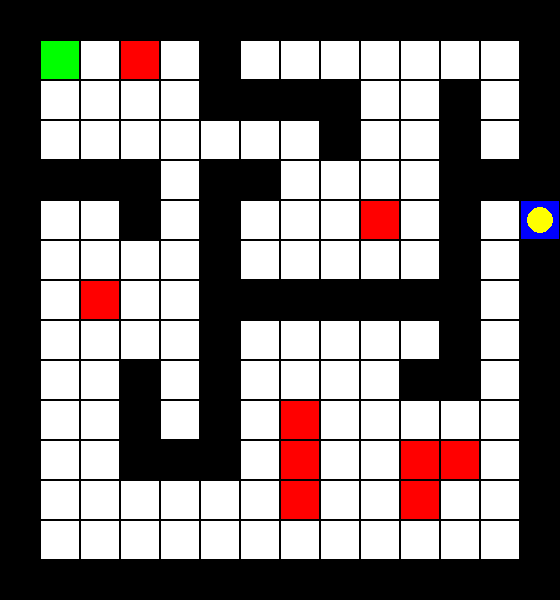

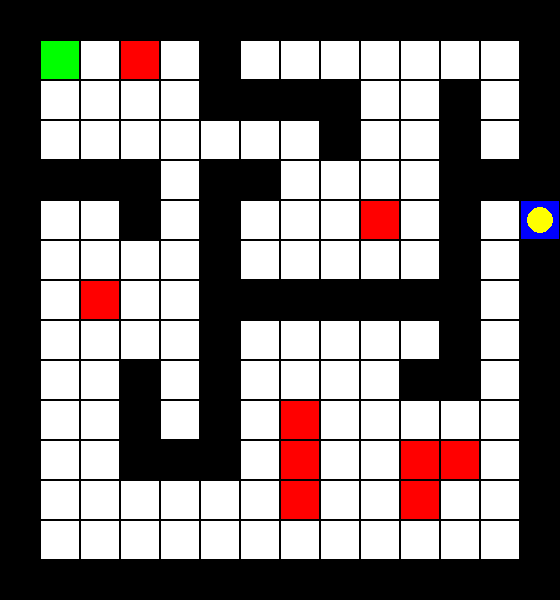

Episode: 3 Score: -387240
Maze image saved as /content/maze_episode_4.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

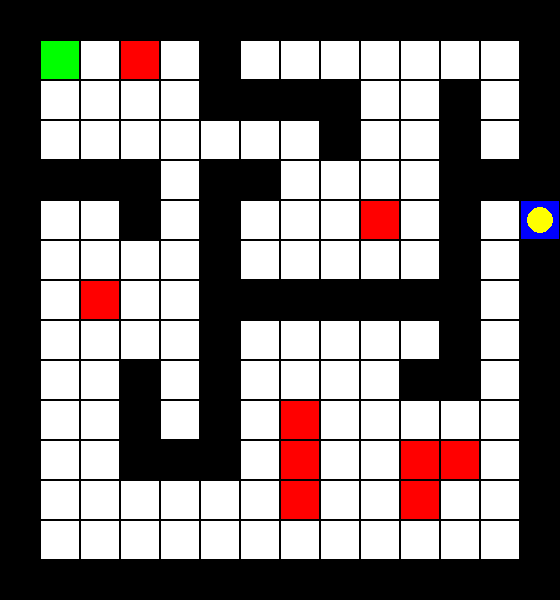

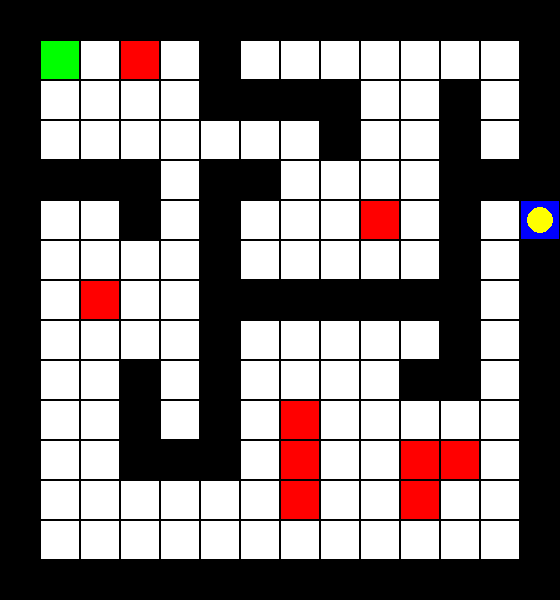

Episode: 4 Score: -579681005
Maze image saved as /content/maze_episode_5.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

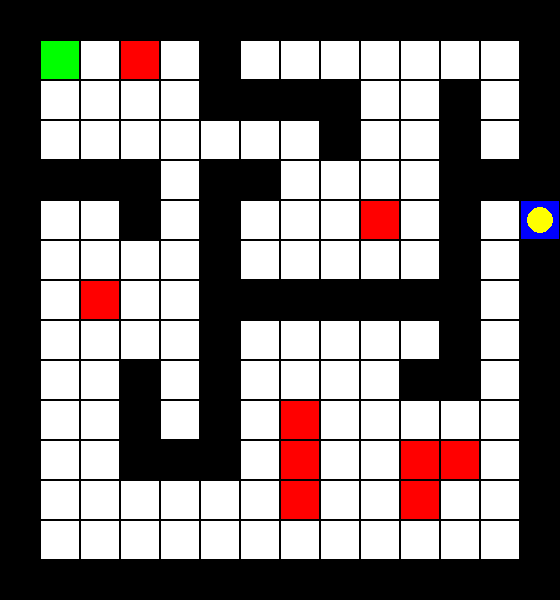

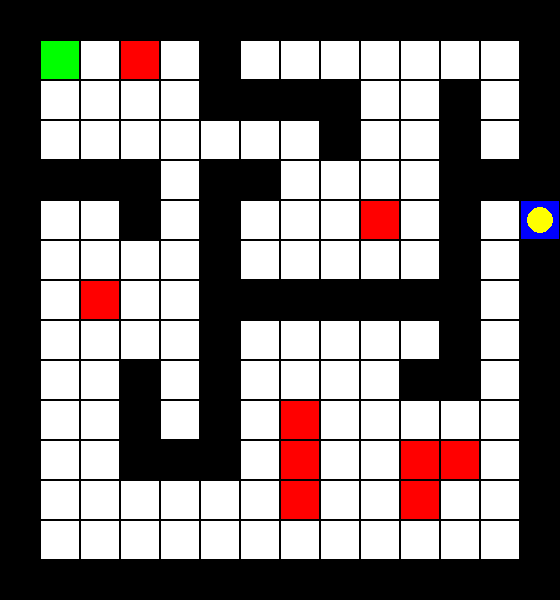

Episode: 5 Score: -73694310
Maze image saved as /content/maze_episode_6.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

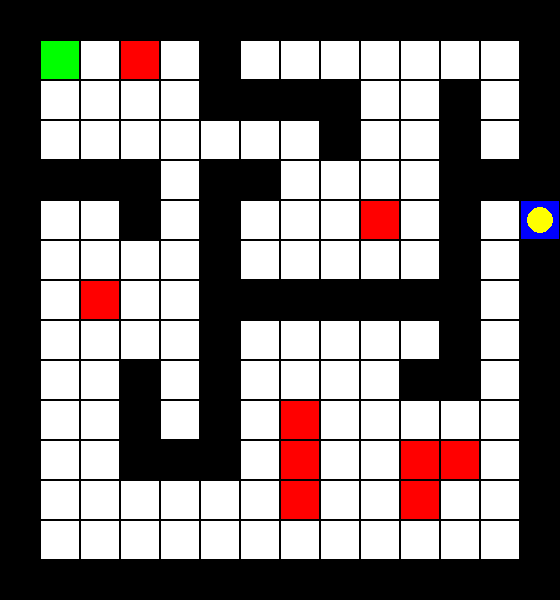

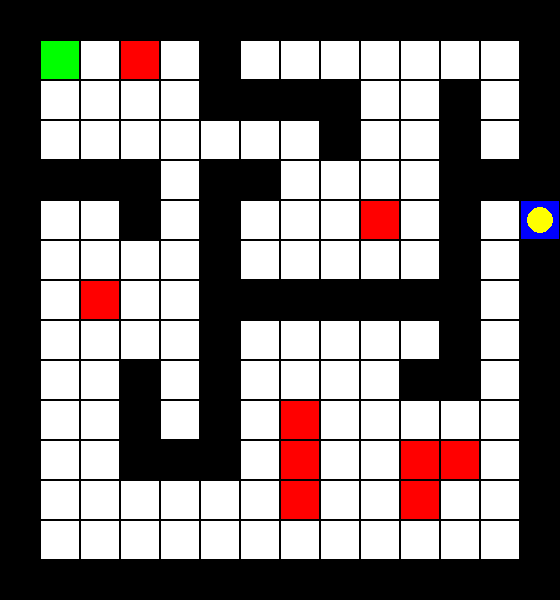

Episode: 6 Score: -1401715
Maze image saved as /content/maze_episode_7.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

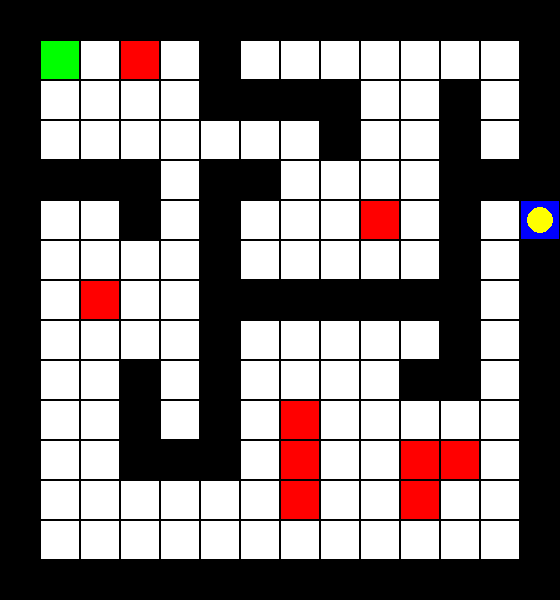

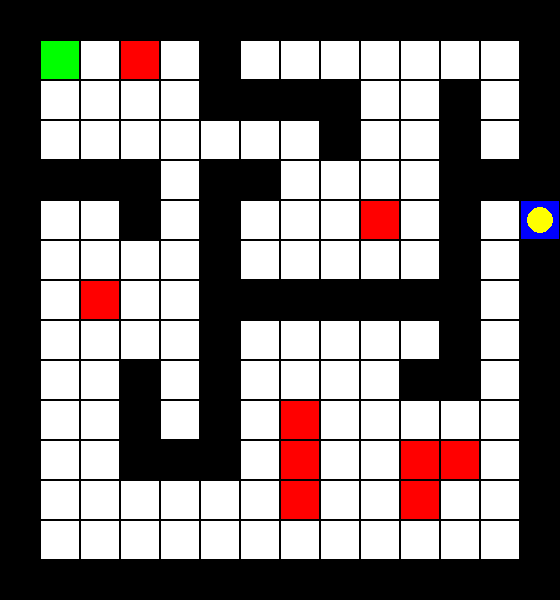

Episode: 7 Score: -56947490
Maze image saved as /content/maze_episode_8.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

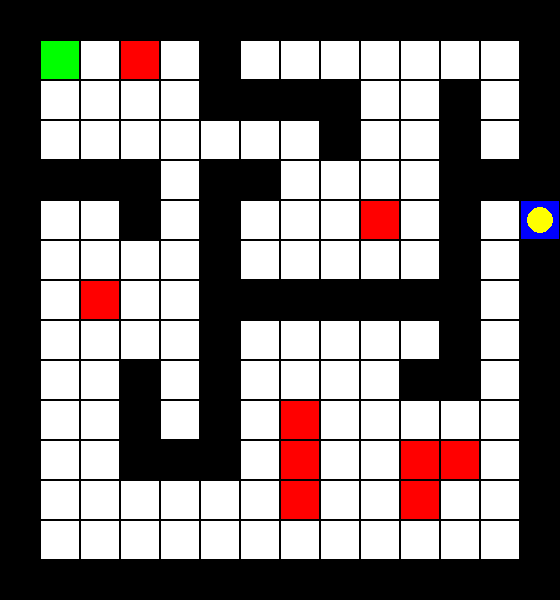

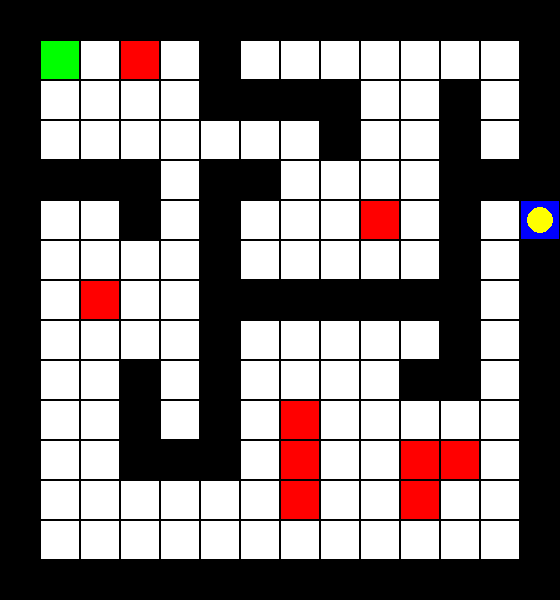

Episode: 8 Score: -1378330
Maze image saved as /content/maze_episode_9.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

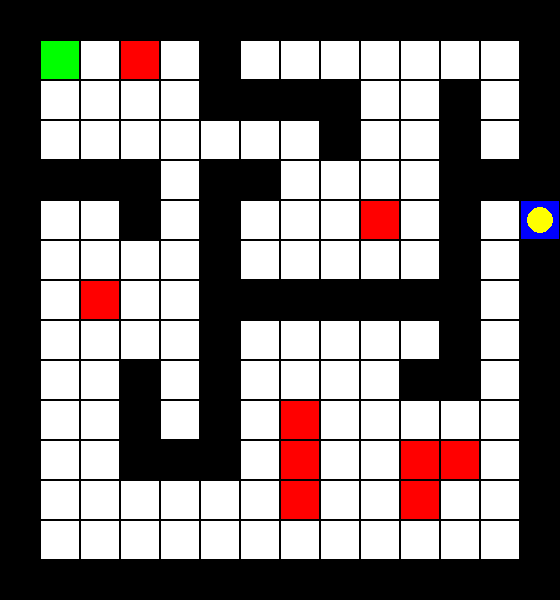

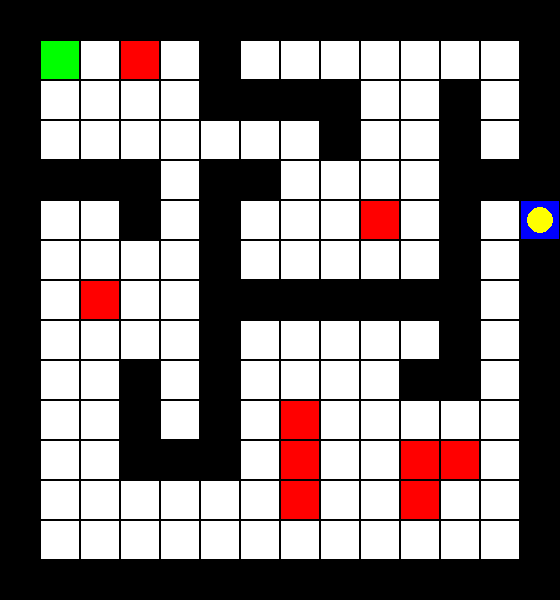

Episode: 9 Score: -18267045
Maze image saved as /content/maze_episode_10.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

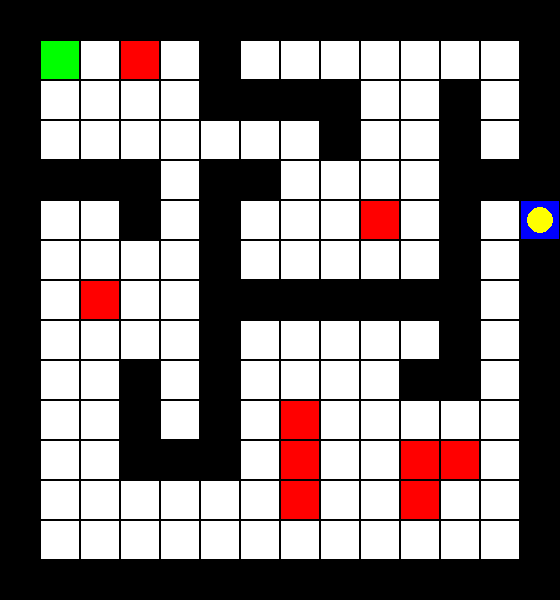

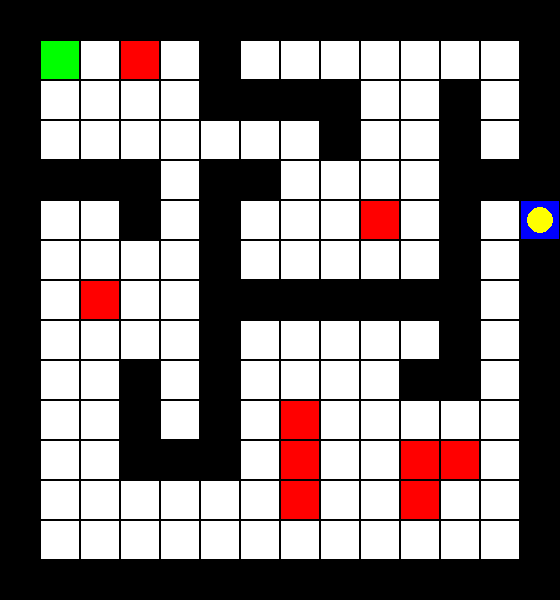

Episode: 10 Score: -90153020
Maze image saved as /content/maze_episode_11.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

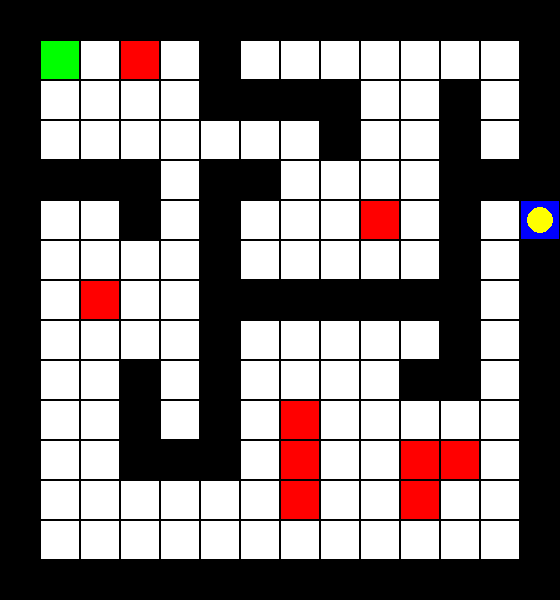

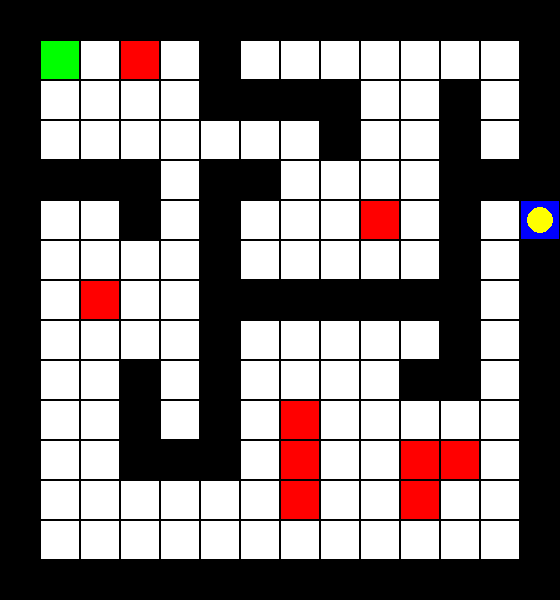

Episode: 11 Score: -224153615
Maze image saved as /content/maze_episode_12.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

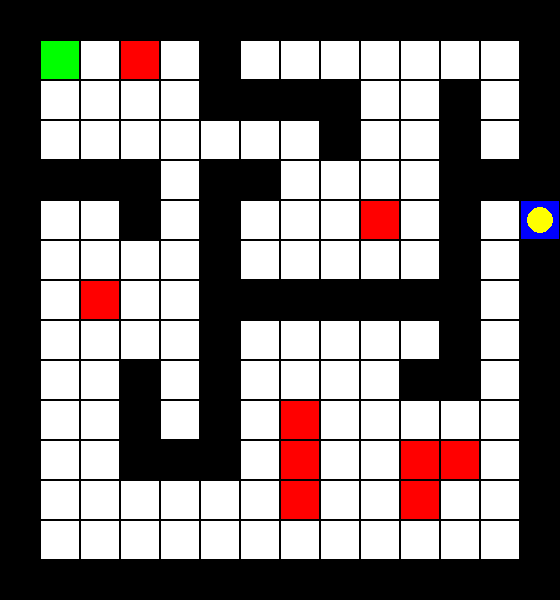

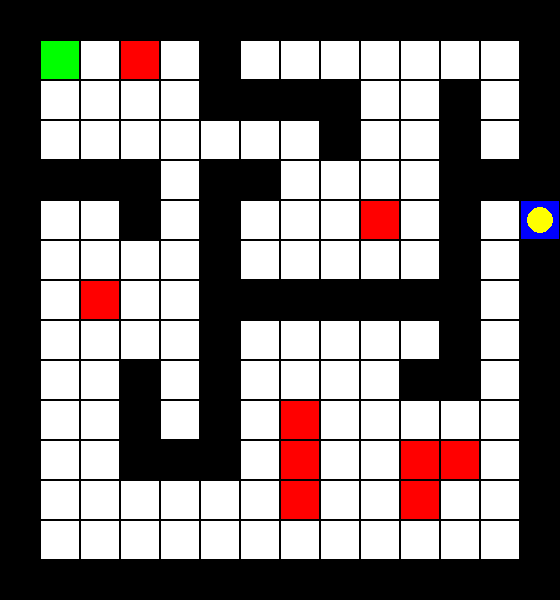

Episode: 12 Score: -50145830
Maze image saved as /content/maze_episode_13.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

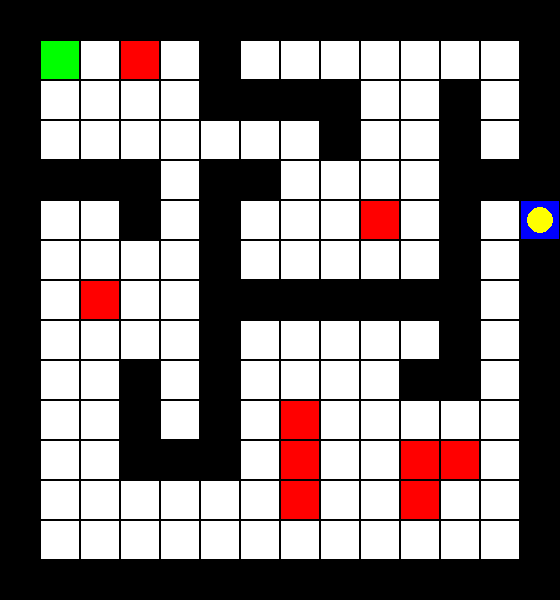

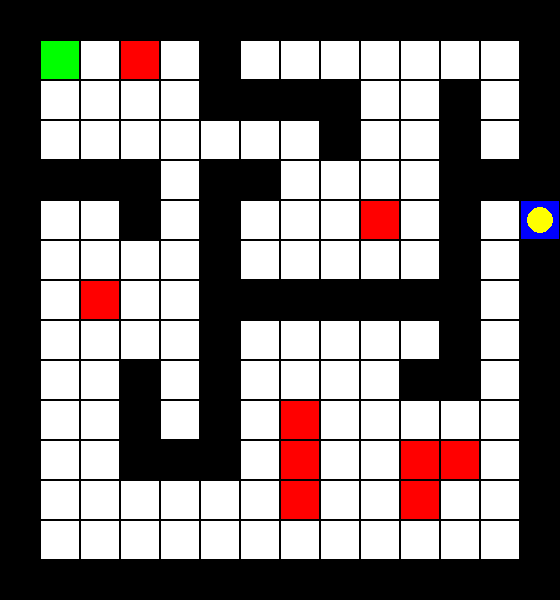

Episode: 13 Score: -271321305
Maze image saved as /content/maze_episode_14.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

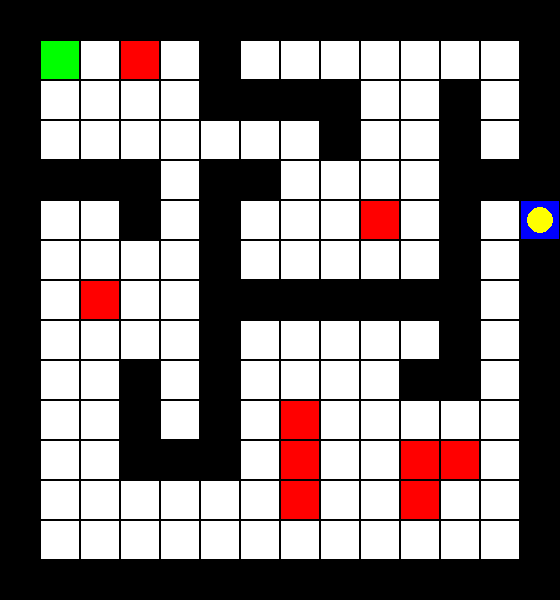

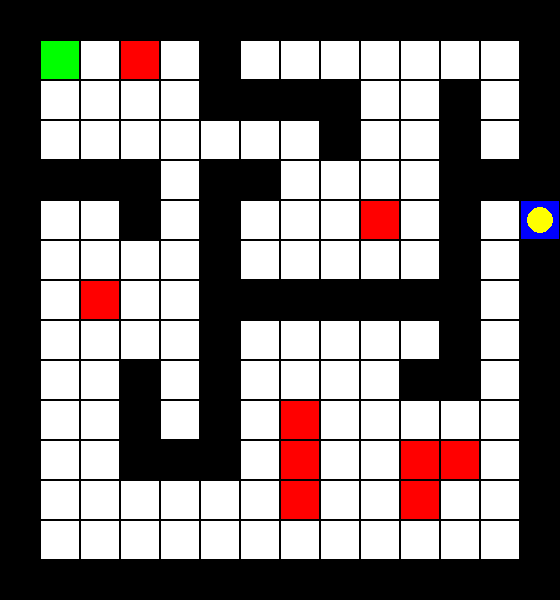

Episode: 14 Score: -2774965
Maze image saved as /content/maze_episode_15.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

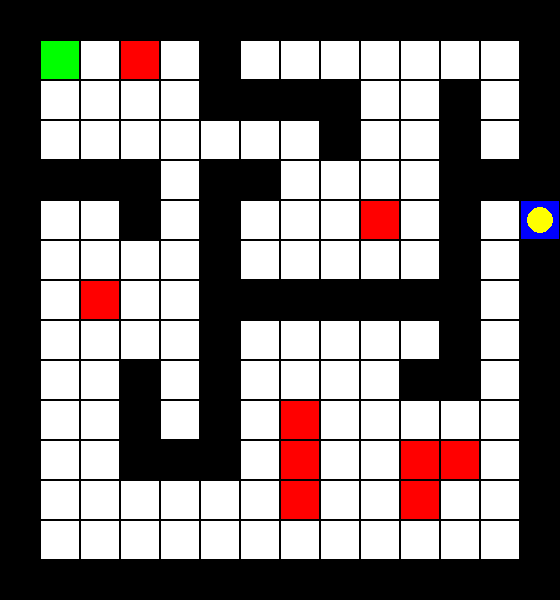

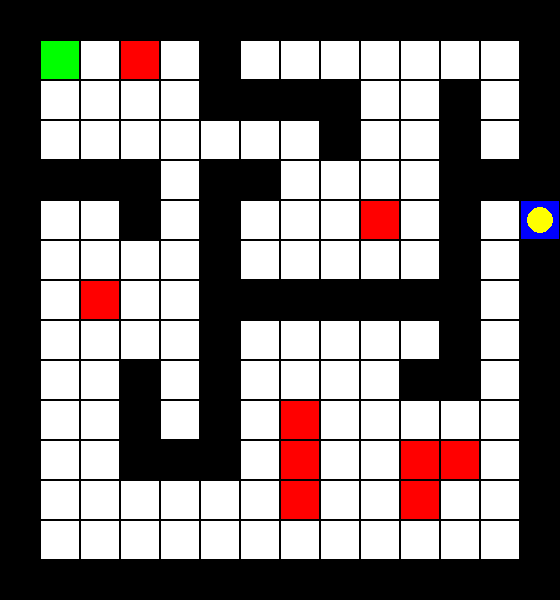

Episode: 15 Score: -280880085
Maze image saved as /content/maze_episode_16.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

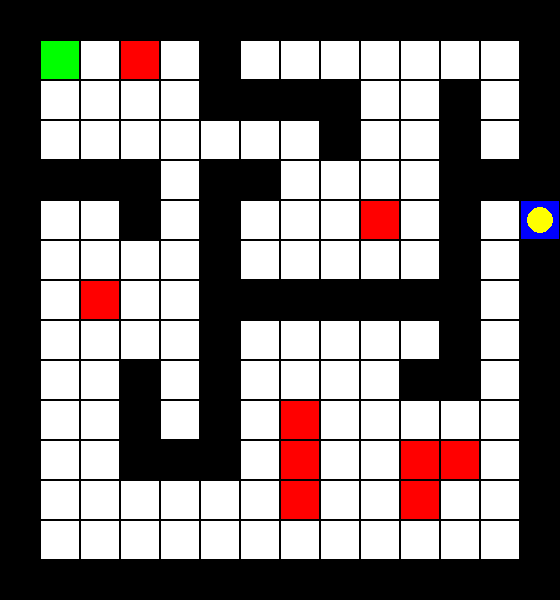

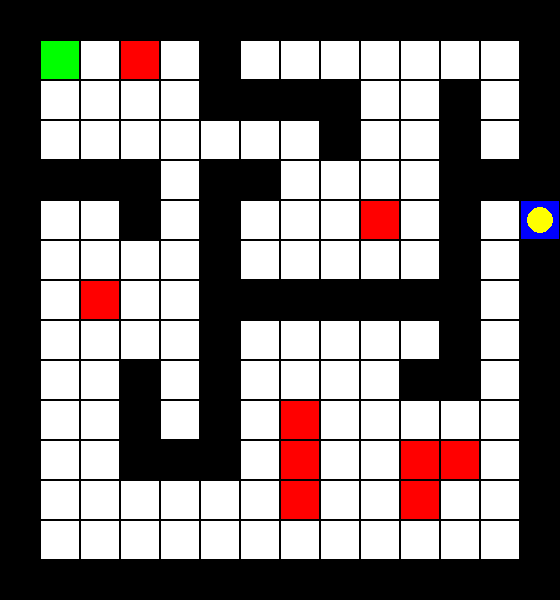

Episode: 16 Score: -388288965
Maze image saved as /content/maze_episode_17.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

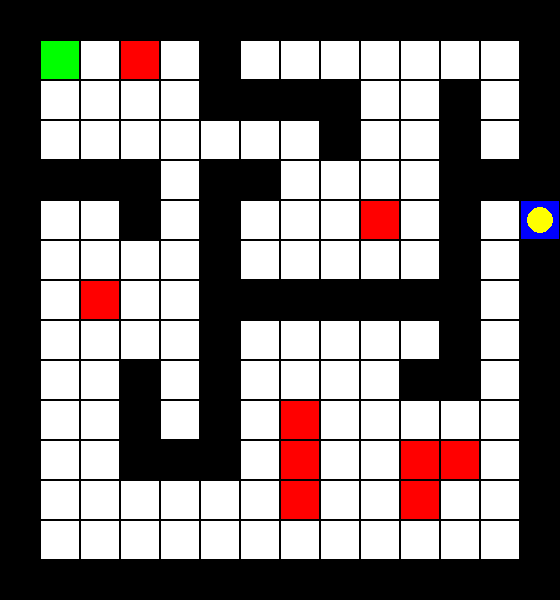

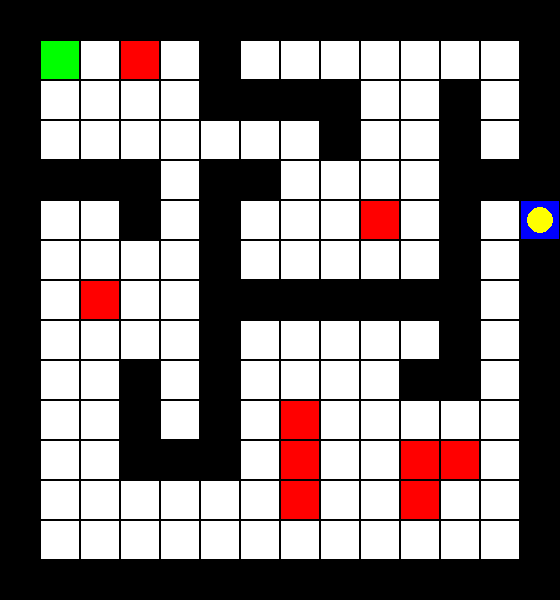

Episode: 17 Score: -3193735
Maze image saved as /content/maze_episode_18.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

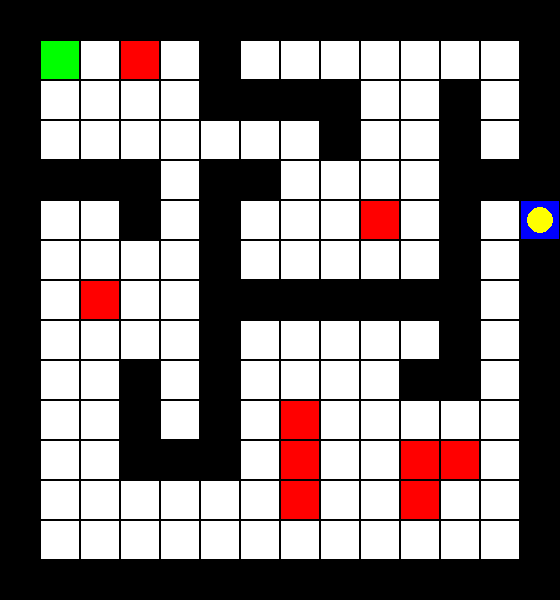

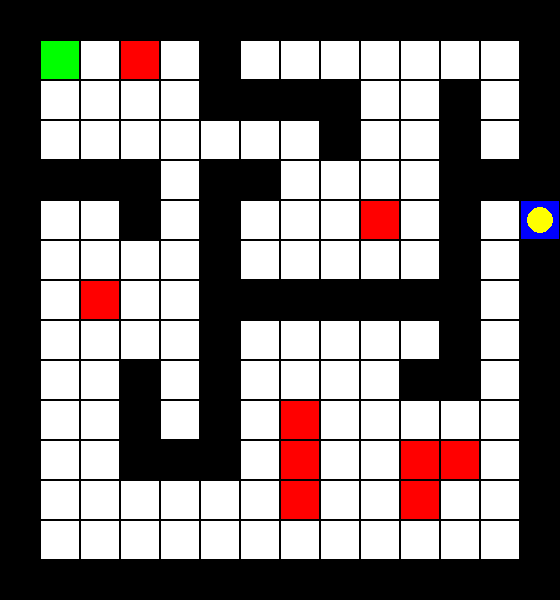

Episode: 18 Score: -14093560
Maze image saved as /content/maze_episode_19.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

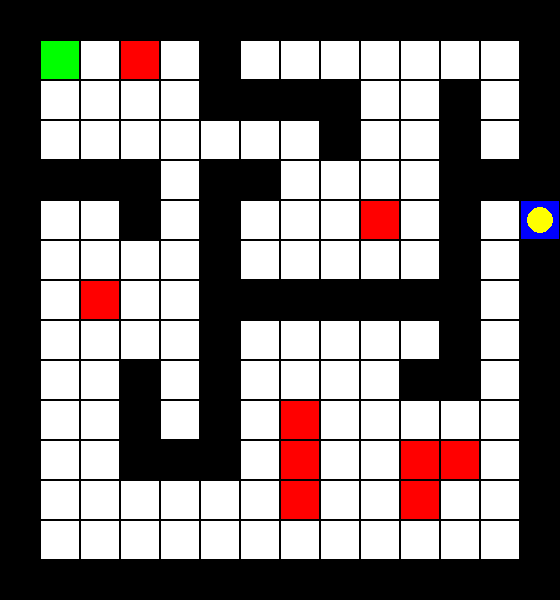

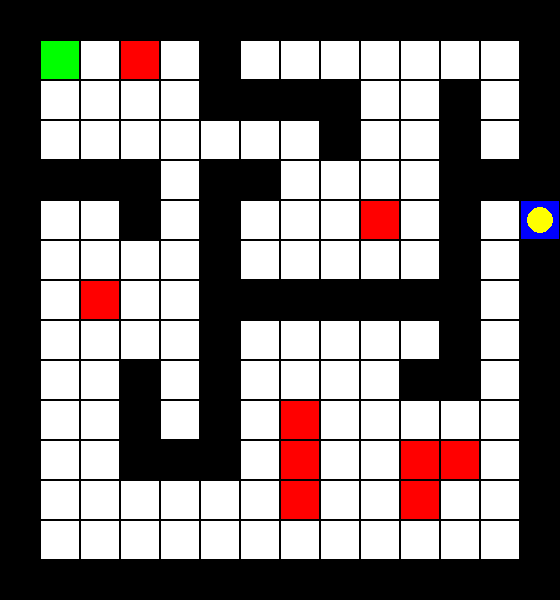

Episode: 19 Score: -23711620
Maze image saved as /content/maze_episode_20.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

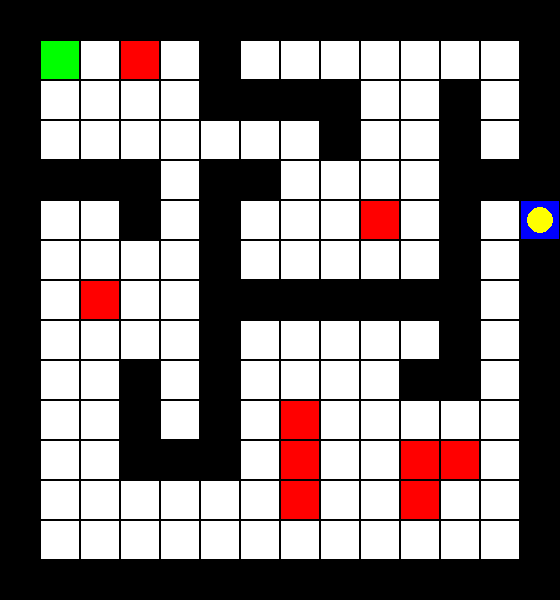

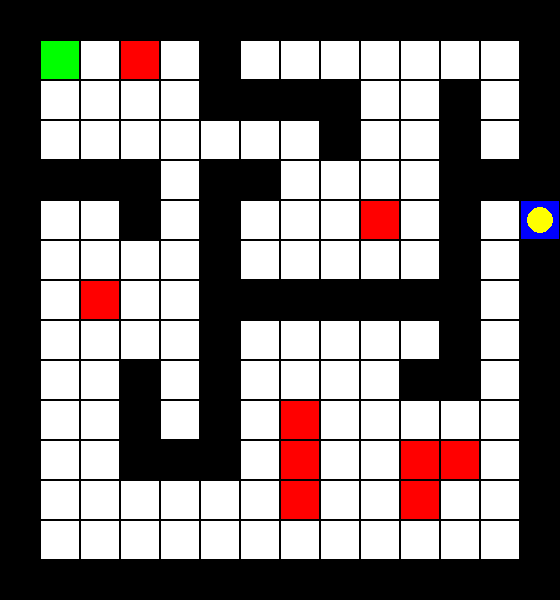

Episode: 20 Score: -4272005


In [ ]:
env = CustomMazeEnv()
episodes = 20

for episode in range(1, episodes + 1):
    state = env.reset()
    done = False
    score = 0

    while not done:
        action = np.random.choice([0, 1, 2, 3])

        n_state, reward, done, maze_value = env.step(action)

        score += reward

    # Save and show the environment image at the end of the episode
    image_path = f"/content/maze_episode_{episode}.png"
    env.render(save_as_image=True, image_path=image_path)

    display(Image(filename=image_path))

    print(f'Episode: {episode} Score: {score}')

    # Pause for visibility
    time.sleep(1)

# **Observation on taking random actions:**<br>
**As seen as in the above cell,the result of taking random actions is awful  as the best number which is 6 numbers after the sign and not even a positive number ,also the result is getting worse by increasing some episodes instead of getting better which means that the agent hitting walls and obstacles many many times without any learning as it's at the end is `Random Taken Actions`, this leads to the importance of building and trainning agent on algorithms like `DQN`.**

# **Trying to display progress of agent taking random actions in a sequence and record it as a video.**

In [ ]:
class CustomMazeEnv(Env):
    def __init__(self, render_mode="rgb_array", record_video=False, output_video_path="agent_demo.mp4"):
        super().__init__()
        self.total_reward = 0  # Initialize cumulative reward
        self.lives = 5  # Set number of lives

        # 0 --> path 1 --> walls 2--> obstacles 3 --> agent 4 --> goal
        self.maze = np.array([
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 3, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1],
            [1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1],
            [1, 0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 1, 0, 4],
            [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
            [1, 0, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
            [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
            [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1],
            [1, 0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1],
            [1, 0, 0, 1, 1, 1, 0, 2, 0, 0, 2, 2, 0, 1],
            [1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
        ])

        # Locate starting and goal positions and set the agent at the start.
        self.start_pos = np.argwhere(self.maze == 3)[0]
        self.goal_pos = np.argwhere(self.maze == 4)[0]
        self.agent_pos = self.start_pos.copy()

        self.action_space = Discrete(4)  # Up, Down, Left, Right
        self.observation_space = Box(low=np.array([0, 0]), high=np.array([14, 13]), dtype=np.int32)

        # sets up the graphical display using Pygame.
        pygame.init()
        pygame.font.init()
        self.font = pygame.font.SysFont(None, 30)  # You can change the size

        self.cell_size = 40
        self.screen = pygame.display.set_mode((self.maze.shape[1] * self.cell_size, self.maze.shape[0] * self.cell_size))
        pygame.display.set_caption("Custom Maze Environment")

        # sets up video recording if enabled.
        self.record_video = record_video
        if self.record_video:
            self.frame_rate = 25
            self.output_video_path = output_video_path
            self.fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            # Creates an OpenCV video writer object.
            self.out = cv2.VideoWriter(self.output_video_path, self.fourcc, self.frame_rate,
                                       (self.maze.shape[1] * self.cell_size, self.maze.shape[0] * self.cell_size))

    # Reset function
    def reset(self):
        self.agent_pos = self.start_pos.copy()
        self.total_reward = 0
        self.lives = 5  # Reset lives on reset
        return np.array(self.agent_pos, dtype=np.int32)

    # Check Obstacle Avoidance
    def _avoided_obstacle(self, old_pos, new_pos):
        x, y = old_pos
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            if (x + dx, y + dy) != new_pos and self.maze[x + dx, y + dy] == 2:
                return True
        return False

    # Step Function
    def step(self, action):
        x, y = self.agent_pos
        old_pos = (x, y)  # get current position

        # Navigation
        if action == 0:
            new_x, new_y = x - 1, y  # up
        elif action == 1:
            new_x, new_y = x + 1, y  # down
        elif action == 2:
            new_x, new_y = x, y - 1  # left
        elif action == 3:
            new_x, new_y = x, y + 1  # right

        done = False
        reward = 0
        expected_maze_value = self.maze[new_x, new_y]

        if expected_maze_value == 1 or expected_maze_value == 2:  # Hit wall or obstacle
            self.lives -= 1
            reward = -10  # Penalty for hitting walls or obstacles
            if self.lives <= 0:  # If no lives are left
                reward = -30  # Apply large penalty
                done = True
        else:
            self.agent_pos = [new_x, new_y]
            if (new_x, new_y) == tuple(self.goal_pos):
                reward = 100
                done = True
            elif self._avoided_obstacle(old_pos, (new_x, new_y)):
                reward = 5

        self.total_reward += reward
        self.current_reward = self.total_reward  # for rendering
        return np.array(self.agent_pos, dtype=np.int32), self.total_reward, done, expected_maze_value

    # Render Function
    def render(self, save_as_image=False, image_path="maze_image.png"):
        self.screen.fill((255, 255, 255))  # Fill screen with white background
        colors = {
            1: (0, 0, 0),   # Walls (black)
            2: (255, 0, 0), # Obstacles (red)
            3: (0, 255, 0), # Agent (green)
            4: (0, 0, 255), # Goal (blue)
            0: (255, 255, 255) # Path (white)
        }

        # Draw the maze
        for r in range(self.maze.shape[0]):
            for c in range(self.maze.shape[1]):
                pygame.draw.rect(
                    self.screen, colors[self.maze[r, c]],
                    (c * self.cell_size, r * self.cell_size, self.cell_size, self.cell_size)
                )
                pygame.draw.rect(
                    self.screen, (0, 0, 0),
                    (c * self.cell_size, r * self.cell_size, self.cell_size, self.cell_size), 1
                )

        # Draw the agent (Yellow circle)
        pygame.draw.circle(
            self.screen, (255, 255, 0),
            (self.agent_pos[1] * self.cell_size + self.cell_size // 2,
            self.agent_pos[0] * self.cell_size + self.cell_size // 2),
            self.cell_size // 3
        )

        # Draw lives in red text
        lives_text = self.font.render(f"Lives: {self.lives}", True, (255, 0, 0))  # Red for lives
        self.screen.blit(lives_text, (self.maze.shape[1] * self.cell_size - 120, 10))  # Top-right corner

        # Draw reward in hot pink
        reward_text = self.font.render(f"Reward: {self.current_reward}", True, (255, 105, 180))  # hot pink
        self.screen.blit(reward_text, (10, 10))  # Top-left corner

        pygame.display.flip()

        # convert screen to an image
        if self.record_video:
            frame = pygame.surfarray.array3d(self.screen)  # Captures the current Pygame screen as an image.
            frame = np.transpose(frame, (1, 0, 2))  # Convert to (height, width, channels) Pygame and OpenCV store images in different orderings
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert from RGB to BGR (for OpenCV)

            # write frame to video
            self.out.write(frame)

        # Save maze as an image
        if save_as_image:
            pygame.image.save(self.screen, image_path)
            print(f"Maze image saved as {image_path}")

    def close(self):
        # Stops video recording and saves the file.
        if self.record_video:
            self.out.release()  # Closes the video file and saves it
            print(f"Video saved to {self.output_video_path}")
            files.download(self.output_video_path)  # Make it downloadable in Google Colab

        pygame.quit()


### Creating recording video function
to be easy to reusable

In [ ]:
def record_agent(env, agent=None, episodes=1):
    env.record_video = True
    obs = env.reset()
    done = False

    for _ in range(episodes):
        obs = env.reset()
        done = False
        while not done:
            if agent:
                action = agent.select_action(obs)
            else:
                action = env.action_space.sample()
            obs, _, done, _ = env.step(action)
            env.render()
    env.close()


In [ ]:
env = CustomMazeEnv(record_video=True, output_video_path="Random_action_demo.mp4")
states=env.observation_space.shape #represented by a 2D coordinate, [row, column]
actions=env.action_space.n

In [ ]:


record_agent(env, episodes=1)

Video saved to Random_action_demo.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 🎥 Random Agent Demo

[Watch the video](https://github.com/HaidyTalaat/Reinforcement-Learning-Project-Maze-Solving-Self-Driving-Car/blob/mariam-random-agent-recording-demo/Random_actions_demo%20.mp4)


In [ ]:
learning_rate_a = 0.001         # learning rate (alpha)
discount_factor_g = 0.9         # discount rate (gamma)
network_sync_rate = 10          # number of steps the agent takes before syncing the policy and target network
replay_memory_size = 1000       # size of replay memory
mini_batch_size = 32            # size of the training data set sampled from the replay memory
episodes =50
epsilon = 1.0                 # exploration rate
epsilon_decay = 0.995           # exploration rate decay
epsilon_min = 0.01              # minimum exploration rate


In [ ]:
def build_model(states, actions):
    model = Sequential()
    model.add(Dense(24, activation='relu', input_shape=states, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(48, activation='relu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(24, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(actions, activation='linear'))
    return model

In [ ]:
model = build_model(states, actions)
target_model = build_model(states, actions)
target_model.set_weights(model.get_weights())

model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate_a))
target_model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate_a))


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 24)                  │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 24)                  │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 48)                  │           1,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48)                  │             192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 24)                  │           1,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,836 (11.08 KB)

 Trainable params: 2,692 (10.52 KB)

 Non-trainable params: 144 (576.00 B)

In [ ]:
from collections import deque
max_size = replay_memory_size
memory = deque(maxlen=max_size)
def store_experience(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))


In [ ]:
def epsilon_greedy_policy(q_values, epsilon, action_space):
    if np.random.rand() <= epsilon:
        return random.choice(range(action_space))
    else:
        return np.argmax(q_values)

In [ ]:
total_rewards = []
total_steps = []
best_reward_so_far = -float('inf')  # Start with a very low value for best reward

for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    step_count = 0
    done = False

    while not done:
        # Predict Q-values from current state using the policy model
        q_values = model.predict(np.array([state]))[0]

        # Select action using epsilon-greedy strategy
        action = epsilon_greedy_policy(q_values, epsilon, action_space=actions)

        # Take the chosen action in the environment
        next_state, reward, done, _ = env.step(action)

        # Store the experience in memory for replay
        store_experience(state, action, reward, next_state, done)

        # Move to the next state
        state = next_state
        total_reward += reward
        step_count += 1

    # Learn from past experiences if we have enough stored
    if len(memory) >= mini_batch_size:
        mini_batch = random.sample(memory, mini_batch_size)
        states_batch = []
        target_q_values_batch = []

        for state_b, action_b, reward_b, next_state_b, done_b in mini_batch:
            # Predict current Q-values for this state
            q_values_current = model.predict(np.array([state_b]))[0]

            # Predict Q-values for next state from the target model
            q_values_next = target_model.predict(np.array([next_state_b]))[0]

            # Bellman update
            if done_b:
                q_values_current[action_b] = reward_b  # No future rewards if terminal
            else:
                q_values_current[action_b] = reward_b + discount_factor_g * np.max(q_values_next)

            # Collect data for batch training
            states_batch.append(state_b)
            target_q_values_batch.append(q_values_current)

        # Train the target model on this mini-batch
        model.fit(np.array(states_batch), np.array(target_q_values_batch), epochs=1, verbose=1)

        #  Sync the target model every N steps for stability
        if step_count % network_sync_rate == 0:
            target_model.set_weights(model.get_weights())

    # Check if the current reward is the best
    if total_reward > best_reward_so_far:
        best_reward_so_far = total_reward  # Update best reward
        model.save_weights('best_dqn_weights.weights.h5')  # Save the best model weights
        print(f"Saved best model at Episode {episode + 1} with Reward: {total_reward}")

    # Update epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Append total reward and steps for analysis
    total_rewards.append(total_reward)
    total_steps.append(step_count)

    # Print progress for the episode
    print(f"Episode {episode + 1}/{episodes} — Reward: {total_reward}, Steps: {step_count}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

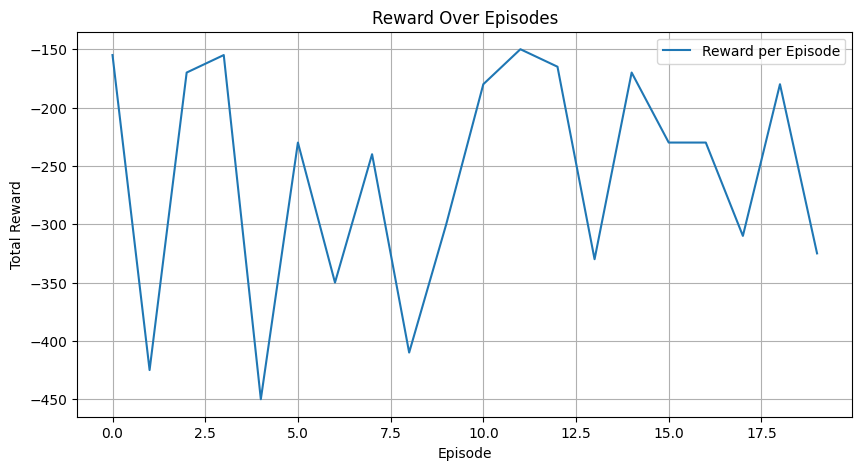

In [ ]:
import matplotlib.pyplot as plt

# Plot rewards over episodes
plt.figure(figsize=(10, 5))
plt.plot(total_rewards, label='Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward Over Episodes')
plt.legend()
plt.grid(True)
plt.show()
